# Notebook to Visualize Huc10 Results - Prototype Model w/ New Data

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from snowML import snow_types as st

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Download MLFlow Metrics

In [3]:
# function to retrieve metrics from ML server 
def load_ml_metrics(tracking_uri, run_id, save_local=False):
    mlflow.set_tracking_uri(tracking_uri)
    client = mlflow.MlflowClient()
    # Get all metric keys from the run
    run_data = client.get_run(run_id).data
    metric_keys = run_data.metrics.keys()
    # Retrieve full metric history for each key
    all_metrics = []
    for metric in metric_keys:
        history = client.get_metric_history(run_id, metric)
        for record in history:
            all_metrics.append({
                "Metric": metric,
                "Step": record.step,
                "Value": record.value
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    # Save to CSV if needed
    if save_local:
        f_out = f"run_id_data/metrics_from_{run_id}.csv"
        metrics_df.to_csv(f_out, index=False)

    return metrics_df

In [4]:
# function to extract only a specific metric
def extract_metric(df, metric_name):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [5]:
# set mlFlow tracking server 
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"

# define our run_ids by recognizable names (all from expiriment "ProtoType Results)
orig_10 = "904143d1cbfe4220afa7878fad6bd9ae" # original data, 10 epochs, MLflow name is intelligent-swan-675 
orig_30 = "0d8be0dc44a447099f7901c83032a59e"  # orig data, 30 epochs, MLflow name is legendary toad 940 
orig_200 = "41f1a7b318f94b2bb2c4fdfbf892a018"  # (orig data, 200 epochs, MLflow name is clumsy-ray-666
new_10 = "f0bde540d8184f7e8ea057456ec56f38" # new data 10 epochs, ML flow name is bittersweet-bug
new_200 = "81757efa26da4005ae1956876ea39a3b"  # new data, 200 epochs, deboniare ape 


In [6]:
df_orig30 = load_ml_metrics(tracking_uri, orig_30)
df_orig30_tkge = extract_metric(df_orig30, "test_kge")
df_orig30_tmse = extract_metric(df_orig30, "test_mse")

df_orig200 = load_ml_metrics(tracking_uri, orig_200)
df_orig200_tkge = extract_metric(df_orig200, "test_kge")
df_orig200_tmse = extract_metric(df_orig200, "test_mse")

df_orig10 = load_ml_metrics(tracking_uri, orig_10)
df_orig10_tkge = extract_metric(df_orig10, "test_kge")
df_orig10_tmse = extract_metric(df_orig10, "test_mse")

df_new10 = load_ml_metrics(tracking_uri, new_10)
df_new10_tkge = extract_metric(df_new10, "test_kge")
df_new10_tmse = extract_metric(df_new10, "test_mse")

df_new200 = load_ml_metrics(tracking_uri, new_200)
df_new200_tkge = extract_metric(df_new200, "test_kge")
df_new200_tmse = extract_metric(df_new200, "test_mse")


In [7]:
# save the metrics files for use offline when MLflow server not running
df_orig30.to_csv("metric_runs/Original30.csv", index=False)  
df_orig200.to_csv("metric_runs/Original200.csv", index=False)  
df_orig10.to_csv("metric_runs/Original10.csv", index=False)  
df_new10.to_csv("metric_runs/New10.csv", index=False)  
df_new200.to_csv("metric_runs/New200.csv", index=False)  

In [8]:
# dispay an example
df_orig200.head()

,Metric,Step,Value
0,1711000505_train_mse,0,0.000015
1,1711000505_test_mse,0,0.011532
2,1711000505_train_kge,0,0.992485
3,1711000505_test_kge,0,0.602654
4,1711000508_train_kge,0,0.997414


# Step 2 - Define Plotting Function

In [26]:
# define a function to plot results side by side 

def plot_side_by_side(*dfs_labels, title = "Side-by-Side Metric Comparison"):
    """Plots a side-by-side bar chart comparing values from multiple DataFrames by Metric.
    
    Parameters:
        *dfs_labels: Variable-length arguments where each pair is (df, label).
                     Example usage: plot_side_by_side(df1, "Label1", df2, "Label2", df3, "Label3")
    """
    
    if len(dfs_labels) % 2 != 0:
        raise ValueError("Arguments must be given as (df1, label1, df2, label2, ...).")
    
    # Process input pairs
    dfs = dfs_labels[0::2]
    labels = dfs_labels[1::2]

    # Merge all DataFrames on 'Metric'
    merged_df = dfs[0][['Metric', 'Value']].rename(columns={'Value': f'Value_{labels[0]}'})
    for df, label in zip(dfs[1:], labels[1:]):
        merged_df = merged_df.merge(df[['Metric', 'Value']], on='Metric', how='inner', suffixes=('', f'_{label}'))
        merged_df = merged_df.rename(columns={'Value': f'Value_{label}'})  # Rename to avoid conflicts

    metrics = merged_df['Metric']
    values = [merged_df[f'Value_{label}'] for label in labels]
    medians = [np.median(val) for val in values]
    
    x = np.arange(len(metrics))  # Label locations
    width = 0.8 / len(labels)  # Adjust bar width dynamically based on the number of datasets
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bars for each dataset
    for i, (val, label, median) in enumerate(zip(values, labels, medians)):
        bars = ax.bar(x + (i - len(labels)/2) * width, val, width, label=label, alpha=0.7)
        color = bars[0].get_facecolor()  # Get the color of the bars
        # Draw a median line for each dataset
        ax.axhline(y=median, color=bars[0].get_facecolor(), linestyle='dashed', linewidth=2, alpha=0.8)
        ax.text(len(metrics) + 0.1, median, f"{label} Median: {median:.2f}", 
                va='center', ha='left', color=color, fontsize=10, fontweight='bold')
       
    ax.set_xlabel("Metric")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.legend()

    plt.show()

# Example usage:
# plot_side_by_side(df1, "Label1", df2, "Label2", df3, "Label3")




# Step 3 Compare Results for varying number of Epochs, Old Data 

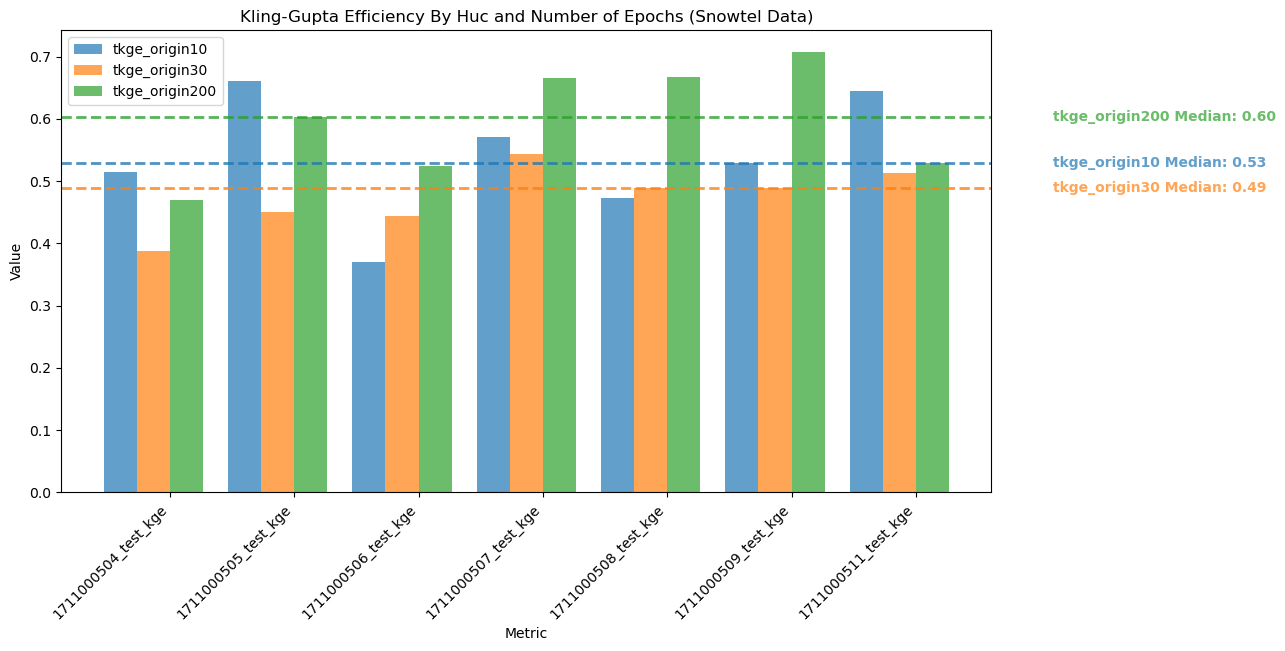

In [27]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
plot_side_by_side(df_orig10_tkge, "tkge_origin10", 
                  df_orig30_tkge, "tkge_origin30", 
                  df_orig200_tkge, "tkge_origin200",
                  title = "Kling-Gupta Efficiency By Huc and Number of Epochs (Snowtel Data)")


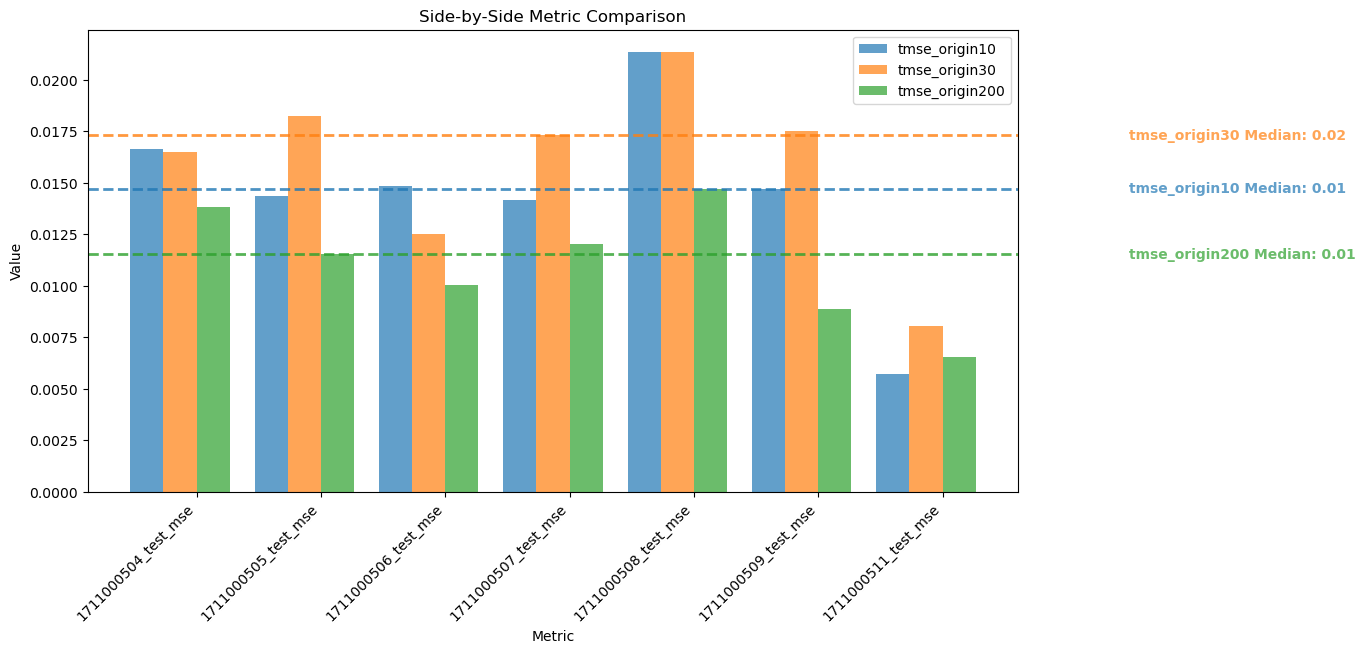

In [13]:
# MSE (Lower is better; 0 is Perfect) 
plot_side_by_side(df_orig10_tmse, "tmse_origin10", df_orig30_tmse, "tmse_origin30", df_orig200_tmse, "tmse_origin200")

# Step 4 Compare Results for varying number of Epochs, New Data 

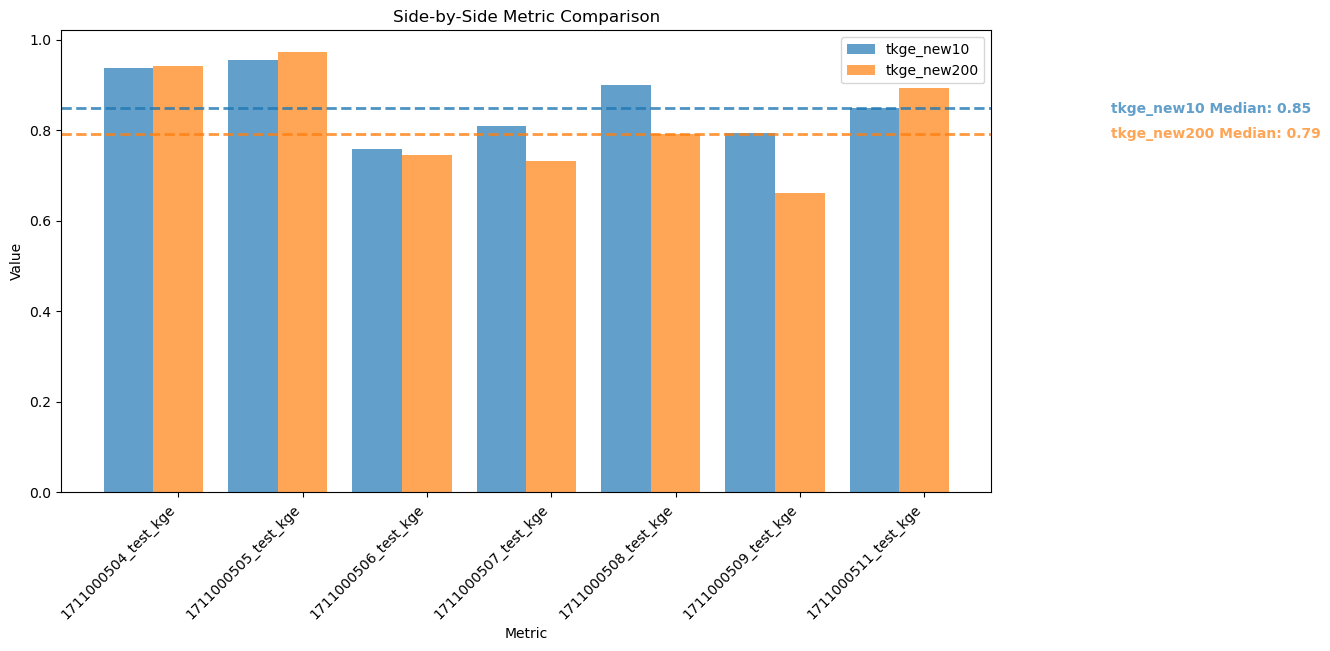

In [14]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
plot_side_by_side(df_new10_tkge, "tkge_new10", df_new200_tkge, "tkge_new200")

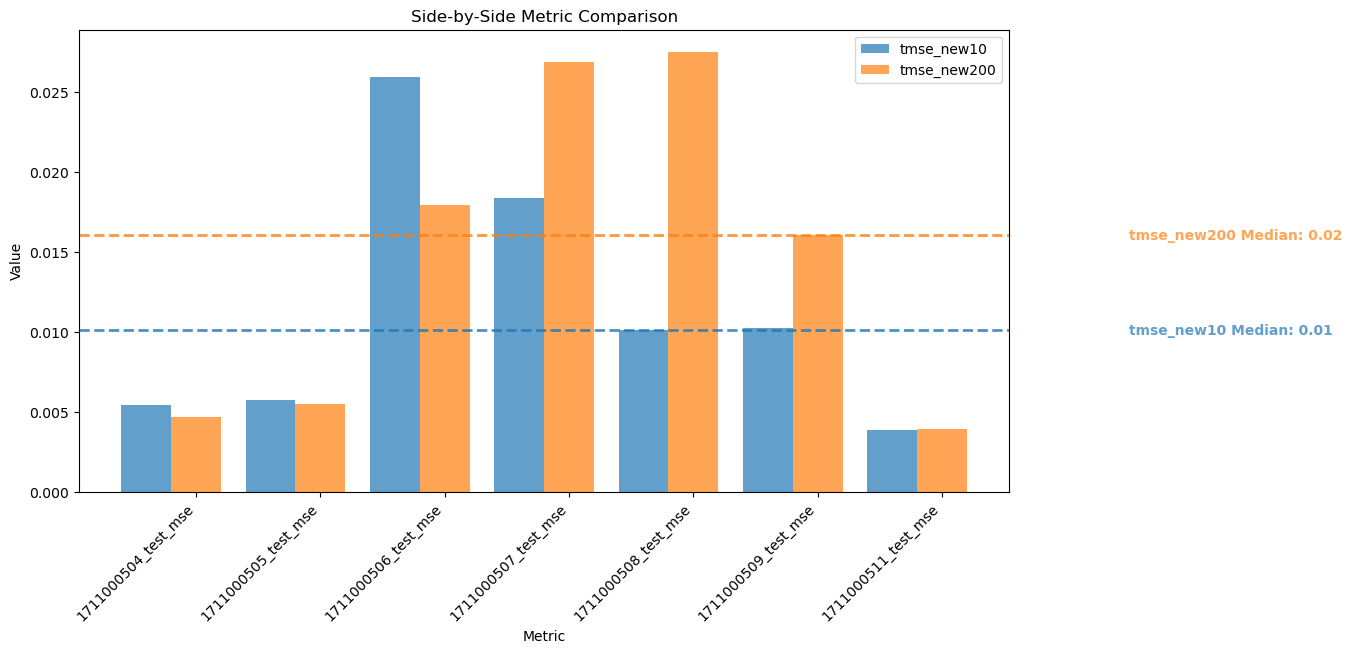

In [15]:
# MSE
plot_side_by_side(df_new10_tmse, "tmse_new10", df_new200_tmse, "tmse_new200")

# Step 5: Compare New Data to Old Data 

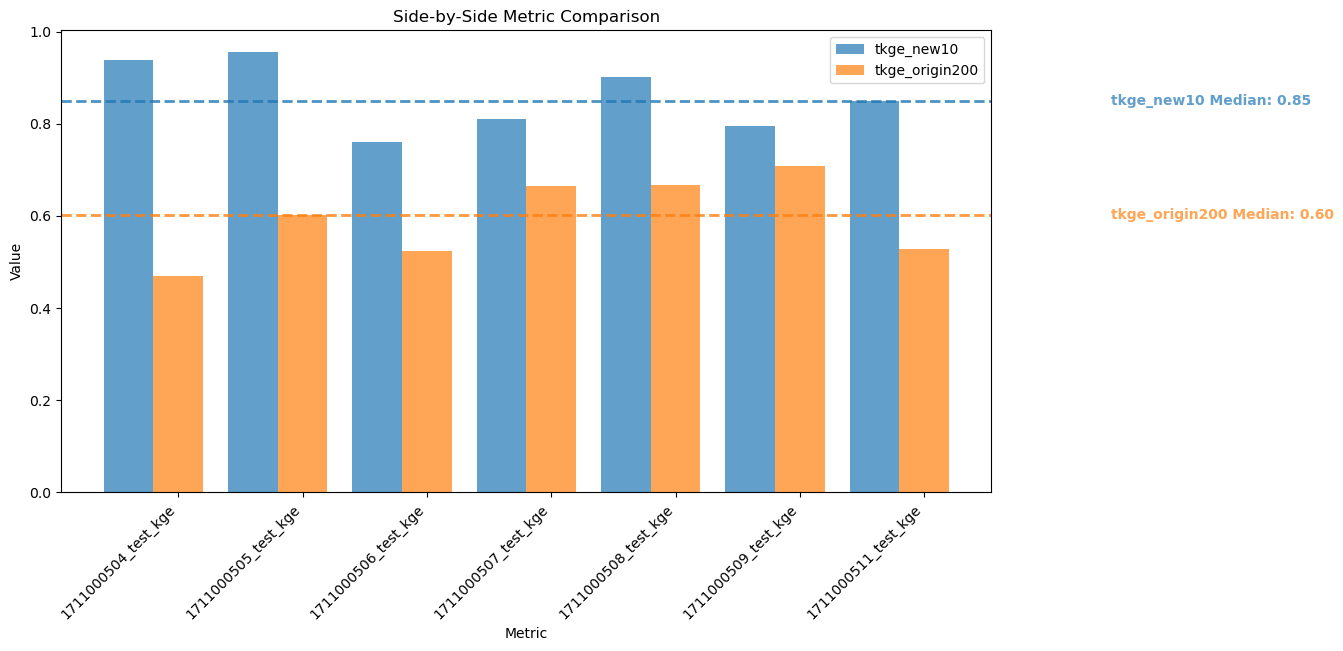

In [16]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
plot_side_by_side(df_new10_tkge, "tkge_new10", df_orig200_tkge, "tkge_origin200")

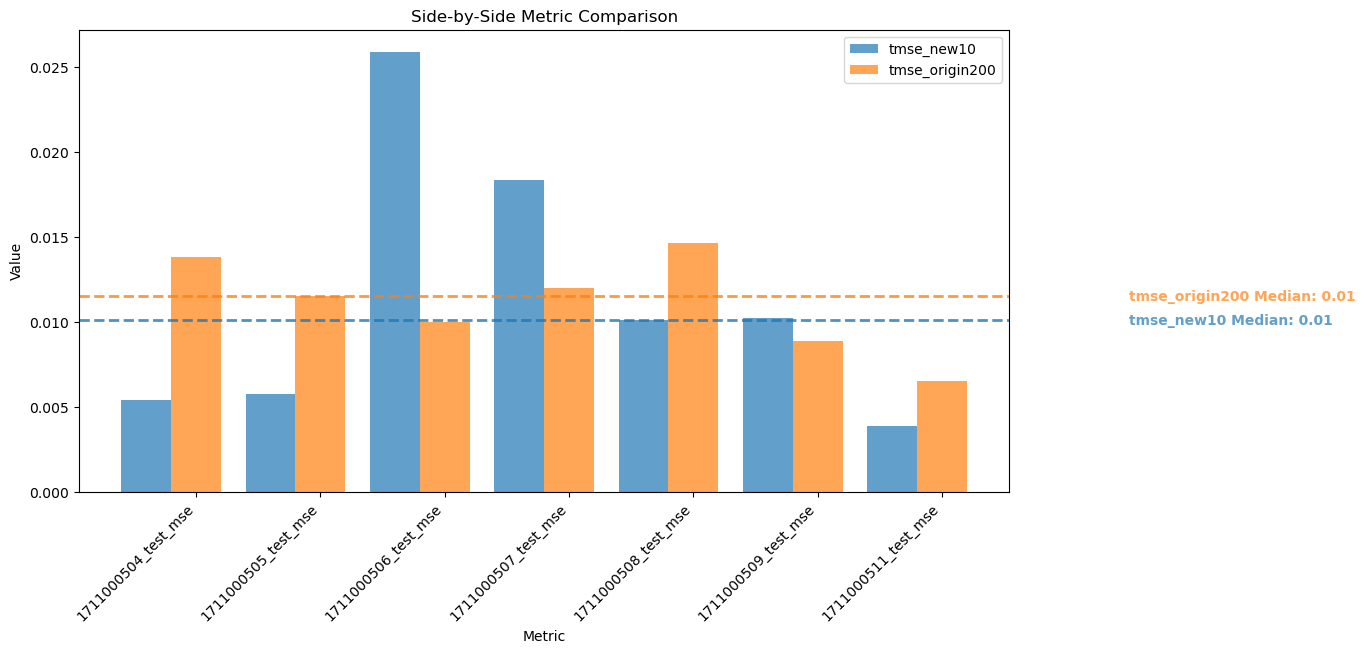

In [21]:
# MSE 
plot_side_by_side(df_new10_tmse, "tmse_new10", df_orig200_tmse, "tmse_origin200")

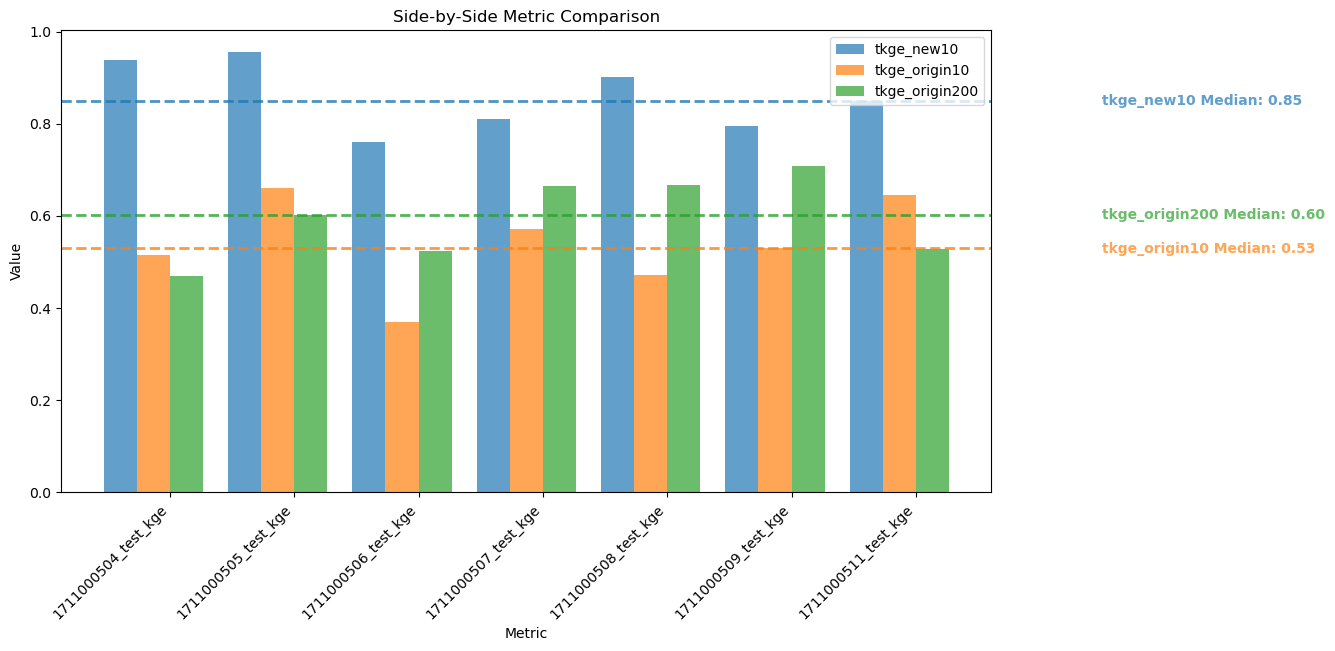

In [18]:
# Klinge-Gupta Efficency (Higher is better; 1 is Perfect) 
plot_side_by_side(df_new10_tkge, "tkge_new10", df_orig10_tkge, "tkge_origin10", df_orig200_tkge, "tkge_origin200")

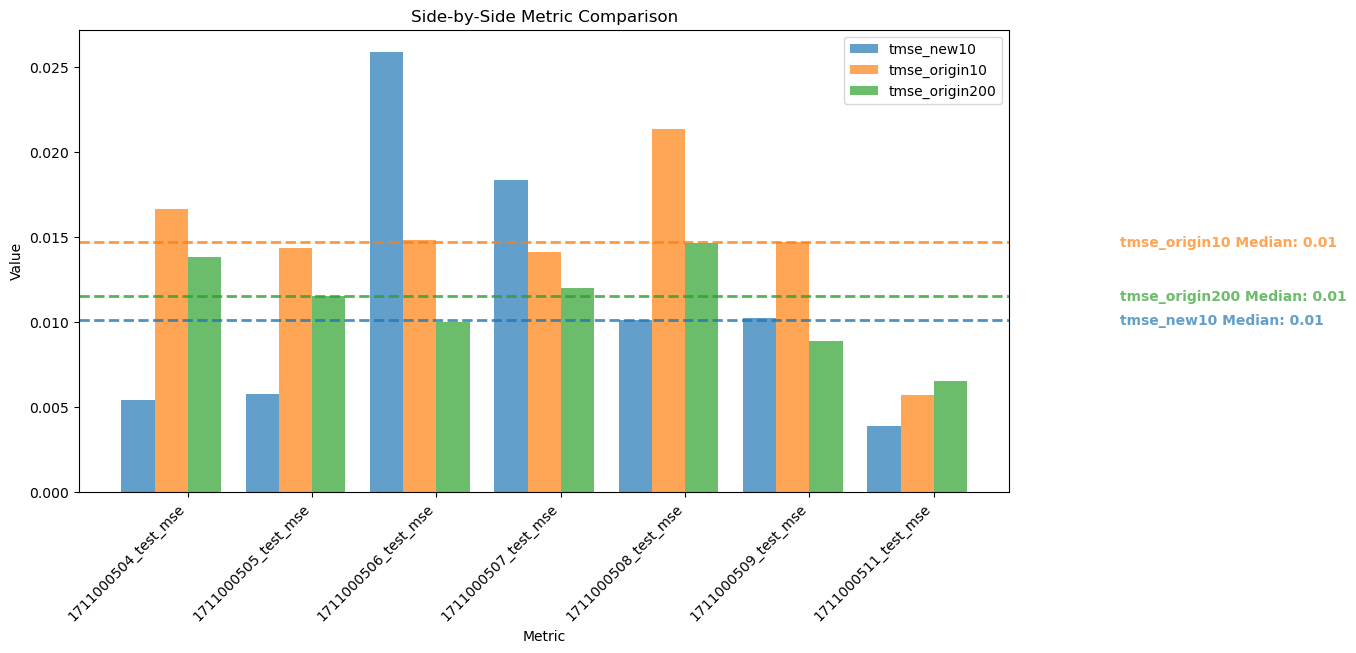

In [19]:
# MSE (Lower is better; 0 is Perfect) 
plot_side_by_side(df_new10_tmse, "tmse_new10", df_orig10_tmse, "tmse_origin10", df_orig200_tmse, "tmse_origin200")